# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

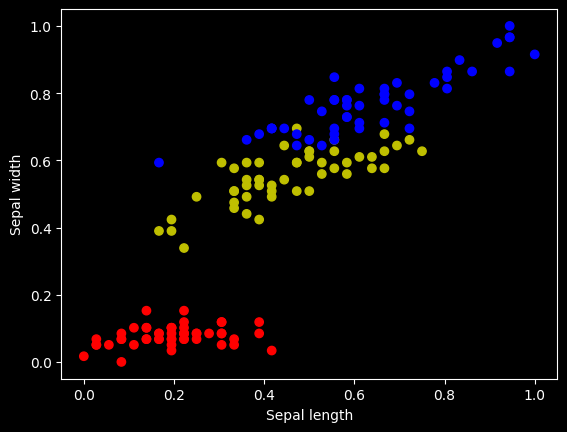

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.2338, -0.6772],
                      [-0.3412, -0.0654],
                      [ 0.1375, -0.2160]])),
             ('bias', tensor([ 0.4732, -0.3325, -0.2050]))])

### Fazendo um predict

In [7]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[ 0.3753, -0.4128, -0.1891],
        [ 0.3883, -0.3938, -0.1968],
        [ 0.4128, -0.3738, -0.2008],
        [ 0.3963, -0.3665, -0.2119]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.4942, 0.2247, 0.2810],
        [0.4964, 0.2271, 0.2765],
        [0.5008, 0.2281, 0.2711],
        [0.4974, 0.2319, 0.2707]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[49.4231, 22.4724, 28.1045],
        [49.6411, 22.7067, 27.6522],
        [50.0793, 22.8066, 27.1141],
        [49.7351, 23.1936, 27.0714]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([0, 0, 0, 0])
tensor([0.4942, 0.4964, 0.5008, 0.4974], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [12]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.2071356326341629


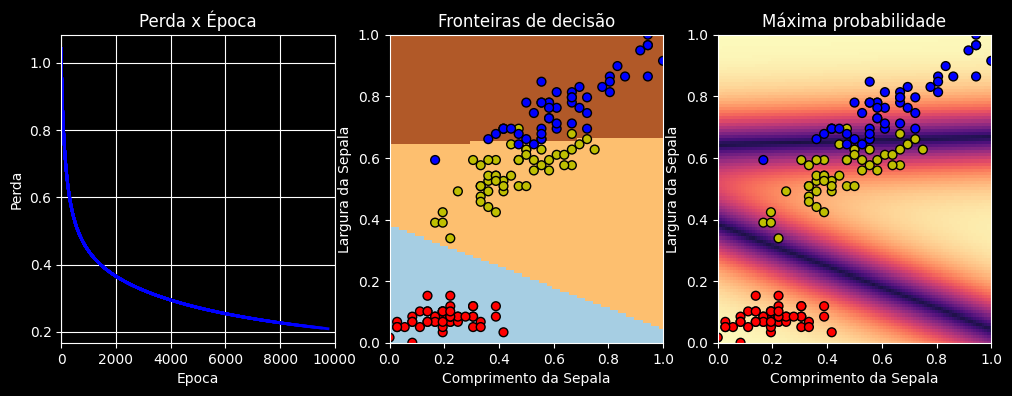

In [13]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.1538, -15.0259],
                      [  1.6020,  -0.9786],
                      [  1.1143,  15.0459]])),
             ('bias', tensor([ 6.9792,  1.6051, -8.6486]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
model.state_dict()

/tmp/ipykernel_33751/952960416.py:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.9792,  1.6051, -8.6486]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.1538, -15.0259],
                      [  1.6020,  -0.9786],
                      [  1.1143,  15.0459]])),
             ('bias', tensor([ 6.9792,  1.6051, -8.6486]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

In [21]:
# Reinicializar os pesos e bias do modelo
nn.init.normal_(model.weight, mean=0.0, std=0.01)  # Inicialização normal
nn.init.constant_(model.bias, 0.0)  # Inicialização constante para o bias

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [22]:
# Set a new learning rate
lr = 0.05

# Reinitialize the model's weights and biases
nn.init.normal_(model.weight, mean=0.0, std=0.01)
nn.init.constant_(model.bias, 0.0)

# Redefine the optimizer with the new learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Retrain the model
losses = []
for i in range(nb_epoch):
    output = model(Variable(X_tensor))
    loss = criterion(output, Variable(Y_tensor))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.data.item())

print('Final loss with learning rate', lr, ':', loss.data.item())

Final loss with learning rate 0.05 : 0.3125028610229492


### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

In [24]:
all_probs = F.softmax(output, dim=1).detach().numpy()

In [27]:
correct_indices = np.where(Y_pred == Y)[0]

correct_probs = all_probs[correct_indices]
max_correct_prob_sample = correct_indices[correct_probs.max(axis=1).argmax()]
max_correct_prob_value = correct_probs.max(axis=1).max()

print(f"Amostra classificada corretamente, com maior probabilidade: {max_correct_prob_sample}, Probabilidade: {max_correct_prob_value}")

Amostra classificada corretamente, com maior probabilidade: 13, Probabilidade: 0.9785431623458862


In [28]:
incorrect_indices = np.where(Y_pred != Y)[0]

incorrect_probs = all_probs[incorrect_indices]

max_incorrect_prob_index = incorrect_probs.max(axis=1).argmax()
max_incorrect_prob_sample = incorrect_indices[max_incorrect_prob_index]
max_incorrect_prob_value = incorrect_probs.max(axis=1).max()

print(f"Amostra classificada erradamente, com maior probabilidade: {max_incorrect_prob_sample}, Probabilidade: {max_incorrect_prob_value}")

Amostra classificada erradamente, com maior probabilidade: 106, Probabilidade: 0.7319638133049011


In [29]:
min_correct_prob_index = correct_probs.max(axis=1).argmin()
min_correct_prob_sample = correct_indices[min_correct_prob_index]
min_correct_prob_value = correct_probs.max(axis=1).min()

print(f"Amostra classificada corretamente, com menor probabilidade: {min_correct_prob_sample}, Probabilidade: {min_correct_prob_value}")

Amostra classificada corretamente, com menor probabilidade: 127, Probabilidade: 0.49837127327919006


In [30]:
min_incorrect_prob_index = incorrect_probs.max(axis=1).argmin()
min_incorrect_prob_sample = incorrect_indices[min_incorrect_prob_index]
min_incorrect_prob_value = incorrect_probs.max(axis=1).min()

print(f"Amostra classificada erradamente, com menor probabilidade: {min_incorrect_prob_sample}, Probabilidade: {min_incorrect_prob_value}")

Amostra classificada erradamente, com menor probabilidade: 126, Probabilidade: 0.5143131613731384


A rede possui um total de **9 parâmetros**:

- **6 parâmetros** da camada densa (2 entradas × 3 saídas = 6 pesos).
- **3 parâmetros** de bias (1 para cada saída).

A rede possui:

- **2 entradas**: correspondentes às características de entrada (comprimento da sépala e comprimento da pétala).
- **3 saídas**: correspondentes às 3 classes do problema de classificação (setosa, versicolor e virginica).

In [31]:
confusion_matrix = pd.crosstab(Y_pred, Y)
accuracy_from_confusion = np.trace(confusion_matrix) / confusion_matrix.values.sum()
print('Acurácia calculada a partir da matriz de confusão:', accuracy_from_confusion)

Acurácia calculada a partir da matriz de confusão: 0.96


A função `torch.max()` é usada para encontrar o valor máximo em um tensor. Ela pode ser utilizada de duas formas principais:

1. **Sem especificar uma dimensão (`dim`)**: Quando chamada sem o parâmetro `dim`, a função retorna o maior valor presente em todo o tensor.

2. **Especificando uma dimensão (`dim`)**: Quando o parâmetro `dim` é especificado, a função retorna dois valores:
    - O maior valor ao longo da dimensão especificada.
    - O índice correspondente ao maior valor nessa dimensão.

Além disso, o parâmetro opcional `keepdim` pode ser usado para manter a dimensão reduzida no resultado, o que é útil para manter a compatibilidade de dimensões em operações subsequentes.

Essa função é amplamente utilizada em tarefas como classificação, onde é necessário identificar a classe com a maior probabilidade (valor máximo) e seu índice correspondente.

In [32]:
tensor = torch.tensor([[1, 3, 2], [4, 0, 5]])
max_values, indices = torch.max(tensor, dim=1)
print(max_values)  # Valores máximos: tensor([3, 5])
print(indices)     # Índices dos máximos: tensor([1, 2])

tensor([3, 5])
tensor([1, 2])


## Principais aprendizados

1. **Problema de Classificação Multiclasse**:
    - O objetivo foi classificar amostras do conjunto de dados Iris em 3 classes (setosa, versicolor e virginica).

2. **Estrutura da Rede Neural**:
    - A rede neural utilizada possui uma camada densa com 2 entradas (características) e 3 saídas (classes).
    - A função de ativação Softmax foi usada para calcular as probabilidades das classes.

3. **Função de Perda**:
    - A função de perda utilizada foi a Entropia Cruzada, adequada para problemas de classificação.

4. **Treinamento da Rede**:
    - O treinamento foi realizado utilizando o otimizador SGD (Gradiente Descendente Estocástico).
    - O aprendizado foi ajustado com diferentes taxas de aprendizado (learning rate).

5. **Visualização Dinâmica**:
    - Foi implementada uma classe para visualizar a evolução da perda e as fronteiras de decisão durante o treinamento.

6. **Avaliação do Modelo**:
    - A acurácia foi calculada tanto diretamente quanto a partir da matriz de confusão.
    - A matriz de confusão foi usada para analisar os acertos e erros do modelo.

7. **Análise de Probabilidades**:
    - Foram identificadas as amostras classificadas corretamente e incorretamente com maior e menor probabilidade.

8. **Inicialização de Pesos**:
    - Diferentes métodos de inicialização de pesos foram explorados para reiniciar o treinamento.

9. **Salvamento e Recuperação de Pesos**:
    - Os pesos treinados foram salvos em um arquivo e posteriormente carregados para reutilização.

10. **Interpretação de Resultados**:
     - A função `torch.max()` foi utilizada para identificar a classe com maior probabilidade.
     - A matriz de confusão foi interpretada para calcular a acurácia e entender o desempenho do modelo.

11. **Parâmetros da Rede**:
     - A rede possui 9 parâmetros no total: 6 pesos (2 entradas × 3 saídas) e 3 bias (1 para cada saída).

12. **Exploração de Hiperparâmetros**:
     - Foi sugerido experimentar diferentes taxas de aprendizado para observar o impacto no treinamento.

13. **Gráficos de Probabilidade**:
     - Gráficos de máxima probabilidade foram utilizados para identificar amostras com maior ou menor confiança na classificação.

14. **Uso de Softmax**:
     - A função Softmax foi utilizada para converter os logitos em probabilidades.

15. **Ferramentas Utilizadas**:
     - Bibliotecas como PyTorch, NumPy, Matplotlib e Pandas foram amplamente utilizadas para modelagem, visualização e análise.